In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

seed = 71
np.random.seed = seed
algorithm_globals.random_seed = seed

In [2]:
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, SLSQP

n = 2
mean = [2**(n-1), 2**(n-1)]
cov = [[1, 0], [0, 1]]
number_of_training_sample = 1000

real_data = np.random.multivariate_normal(mean, cov, number_of_training_sample)
num_qubits = [n, n]
bounds = [[0, 2**n-1], [0, 2**n-1]]
num_epochs = 300
batch_size = 100


qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed)

# Set an initial state for the generator circuit as a uniform distribution
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement='linear', reps=3)




# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/var/folders/26/bfg4nt4s0f17qx8ryxwcpmsw0000gn/T/ipykernel_54535/1662784960.py:25: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


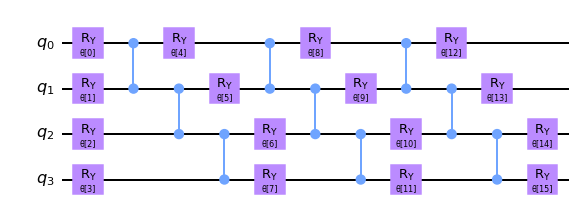

In [3]:
ansatz.decompose().draw('mpl')

In [4]:
# Run qGAN for "number_of_trial" runs and find the best trial with the minimum relative entropy
result_set = {}
number_of_trial = 5
for trial in range(number_of_trial):
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
    result = qgan.run(quantum_instance)
    result_set[trial] = [result['params_g'], result['rel_entr']]
    print(trial, result['rel_entr'])
    trial += 1
    
minimum_relative_entropy_trial = 0
for trial in range(number_of_trial):
    if(result_set[trial][1] < result_set[minimum_relative_entropy_trial][1]): 
        minimum_relative_entropy_trial = trial    

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=result_set[minimum_relative_entropy_trial][0])
result = qgan.run(quantum_instance)

0 0.7782
1 1.2232
2 1.0984
3 2.0157
4 1.8643


In [5]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [-0.70535735 -0.18861503  0.54999847 ...  0.93563987 -0.84241938
  0.84787741]
  params_g : [5.86150474 1.78892755 2.61677293 5.72152483 2.26473505 0.38230787
 5.61153324 0.27402378 4.45707297 4.36697741 6.03955697 2.86641719
 3.94357517 5.52938681 3.54962956 1.50039215]
  loss_d : 0.4896
  loss_g : [0.7221]
  rel_entr : 0.6984


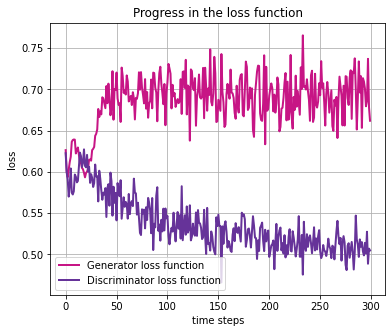

In [6]:
# Plot progress w.r.t the generator's and the discriminator's loss function
initial = num_epochs*minimum_relative_entropy_trial
final = num_epochs*(minimum_relative_entropy_trial+1)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss[initial:final], label="Generator loss function", color="mediumvioletred", linewidth=2)
plt.plot(t_steps, qgan.d_loss[initial:final], label="Discriminator loss function", color="rebeccapurple", linewidth=2)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

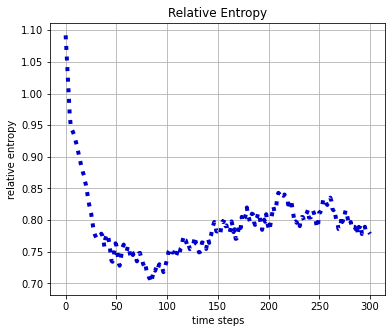

In [7]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr[initial:final])), qgan.rel_entr[initial:final], color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

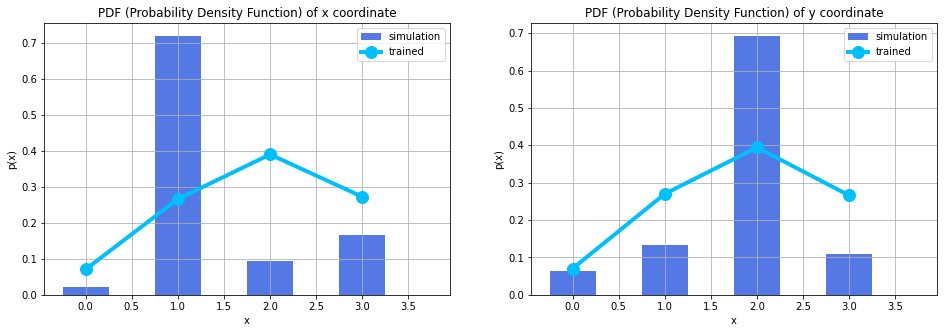

In [65]:
# # # Plot the CDF of the resulting distribution against the target distribution, i.e. log-gaussian
# gaussian = np.random.multivariate_normal(mean, [[0.15, 0.15],[0.15, 0.15]], number_of_training_sample).T
gaussian = np.random.multivariate_normal(mean, cov, number_of_training_sample).T
gaussian_x = np.round(gaussian[0])
gaussian_x = gaussian_x[gaussian_x >= bounds[0][0]]
gaussian_x = gaussian_x[gaussian_x <= bounds[0][1]]
gaussian_y = np.round(gaussian[1])
gaussian_y = gaussian_y[gaussian_y >= bounds[1][0]]
gaussian_y = gaussian_y[gaussian_y <= bounds[1][1]]
gaussian_discretized = [gaussian_x, gaussian_y]
temp_x = []
temp_y = []
for i in range(int(bounds[0][1] + 1)):
    temp_x += [np.sum(gaussian_x == i)]
    temp_y += [np.sum(gaussian_y == i)]
gaussian_x = np.array(temp_x / sum(temp_x))
gaussian_y = np.array(temp_y / sum(temp_y))



samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
m=2**num_qubits[0]
dist = np.reshape(prob_g, (m, m)).T
inds=np.random.choice(np.arange(m**2), p=dist.reshape(-1), size=2000, replace=True)
sampling = np.array([inds//m, inds%m]).T

# prob_1d_x = [prob_g[0]+prob_g[4]+prob_g[8]+prob_g[12],
#             prob_g[1]+prob_g[5]+prob_g[9]+prob_g[13],
#             prob_g[2]+prob_g[6]+prob_g[10]+prob_g[14],
#             prob_g[3]+prob_g[7]+prob_g[11]+prob_g[15]]
# prob_1d_y = [prob_g[0]+prob_g[1]+prob_g[2]+prob_g[3],
#             prob_g[4]+prob_g[5]+prob_g[6]+prob_g[7],
#             prob_g[8]+prob_g[9]+prob_g[10]+prob_g[11],
#             prob_g[12]+prob_g[13]+prob_g[14]+prob_g[15]]


plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title("PDF (Probability Density Function) of x coordinate")
plt.hist(sampling.T[0], density=True, alpha=0.9, color='royalblue', width=0.5, label='simulation', bins=[0-0.25,1-0.25,2-0.25,3-0.25,4-0.25])
plt.plot(gaussian_x, "-o", label="trained", color="deepskyblue", linewidth=4, markersize=12)
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("PDF (Probability Density Function) of y coordinate")
plt.hist(sampling.T[1], density=True, alpha=0.9, color='royalblue', width=0.5, label='simulation', bins=[0-0.25,1-0.25,2-0.25,3-0.25,4-0.25])
plt.plot(gaussian_y, "-o", label="trained", color="deepskyblue", linewidth=4, markersize=12)
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()


/Users/minjaejo/opt/anaconda3/envs/JointProbDist/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minjaejo/opt/anaconda3/envs/JointProbDist/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/minjaejo/opt/anaconda3/envs/JointProbDist/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (

<AxesSubplot:xlabel='Density'>

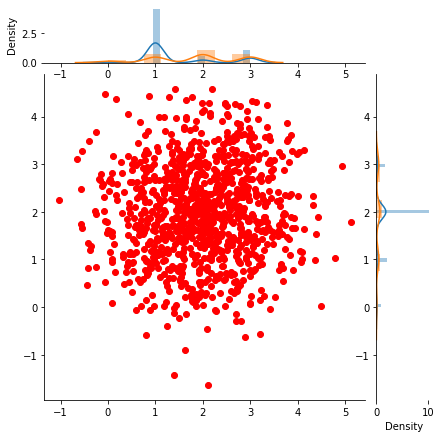

In [66]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm



axs = sns.jointplot(gaussian[0], gaussian[1])
axs.ax_joint.scatter(gaussian[0], gaussian[1], c='r')

axs.ax_marg_x.cla()
axs.ax_marg_y.cla()
sns.distplot(sampling.T[0], ax=axs.ax_marg_x)
sns.distplot(gaussian_discretized[0], ax=axs.ax_marg_x)
sns.distplot(sampling.T[1], ax=axs.ax_marg_y, vertical=True)
sns.distplot(gaussian_discretized[1], ax=axs.ax_marg_y, vertical=True)
